In [15]:
IMG_SIZE = 256 # Taille nécessaire pour MobileNet

In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from matplotlib import cm
from pathlib import Path
from IPython.display import Image, display

In [17]:
# 1. Charger le modèle pré-entrainé

# Charger le modèle pré-entrainé
model = load_model('/content/drive/MyDrive/MODELE 1 LOIC/model2.h5')


# Charger et prétraiter l'image

image_path = '/content/drive/MyDrive/MODELE 1 LOIC/Melanoma.jpg'  # Remplacer par le chemin de votre image
img = image.load_img(image_path, target_size=(256, 256))  # Redimensionner à 256x256
img_array = image.img_to_array(img)

# Normalisation de l'image (en fonction de l'entraînement de votre modèle)
img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch
img_array /= 255.0  # Normaliser les pixels entre 0 et 1


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/drive/MyDrive/MODELE 1 LOIC/model2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
prediction = model.predict(img_array)
print("Prédiction : ", "Bénin" if prediction[0][0] < 0.5 else "Malin")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prédiction :  Malin


In [ ]:
#last_conv_layer_name

# 3. Définir la couche de convolution et les noms des couches du classificateur
base_model = model.layers[0]
last_conv_layer_name = base_model.layers[-1].name  # Dernière couche
print("Last Conv Layer:", last_conv_layer_name)

# Récupérer les 20 dernières couches
last_20_layers = base_model.layers[-20:]

# Afficher les noms des 20 dernières couches
for layer in last_20_layers:
    print(layer.name)



Last Conv Layer: out_relu
block_15_expand
block_15_expand_BN
block_15_expand_relu
block_15_depthwise
block_15_depthwise_BN
block_15_depthwise_relu
block_15_project
block_15_project_BN
block_15_add
block_16_expand
block_16_expand_BN
block_16_expand_relu
block_16_depthwise
block_16_depthwise_BN
block_16_depthwise_relu
block_16_project
block_16_project_BN
Conv_1
Conv_1_bn
out_relu


In [ ]:
#classifier_conv_layer_name/ noms des couches du classificateur
classifier_layer_names = [layer.name for layer in model.layers][1:]
print("Classifier Layers: ", classifier_layer_names)

Classifier Layers:  ['global_average_pooling2d', 'dense', 'dropout', 'dense_1', 'dropout_1', 'dense_2']


In [ ]:
def make_gradcam_heatmap(img_array, base_model, model, last_conv_layer_name, classifier_layer_names):
    last_conv_layer = base_model.get_layer(last_conv_layer_name)
    last_conv_layer_model = tf.keras.Model(inputs=base_model.inputs, outputs=last_conv_layer.output)

    classifier_input = tf.keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = tf.keras.Model(classifier_input, x)

    with tf.GradientTape() as tape:
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    grads = tape.gradient(top_class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(last_conv_layer_output, axis=-1)
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

In [ ]:
 #Générer la heatmap
heatmap = make_gradcam_heatmap(img_array, base_model, model, last_conv_layer_name, classifier_layer_names)

# Convertir la heatmap pour affichage
heatmap = np.uint8(255 * heatmap)
jet = cm.get_cmap("jet")
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# Convertir la heatmap en image et redimensionner
jet_heatmap = keras_image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img_array.shape[1], img_array.shape[2]))  # Redimensionner à la taille originale
jet_heatmap = keras_image.img_to_array(jet_heatmap)

# Superposer la heatmap sur l'image originale
superimposed_img = jet_heatmap * 0.003 + img_array[0]
superimposed_img = keras_image.array_to_img(superimposed_img)


<ipython-input-73-acd40544b9d7>:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


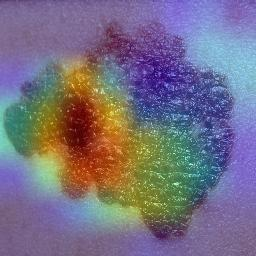

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Prédiction :  Malin


In [ ]:
# Sauvegarder l'image superposée
save_path = "saved_img.jpg"
superimposed_img.save(save_path)

# Affichage de l'image avec la heatmap superposée
display(Image(save_path))

# Afficher la prédiction finale
prediction = model.predict(img_array)
print("Prédiction : ", "Bénin" if prediction[0][0] < 0.5 else "Malin")
